In [4]:
import numpy as np
import pandas as pd
from scipy import signal
from matplotlib import pyplot as plt
data = pd.read_csv('../data/train.csv')

In [5]:
# Use DataFrame.head() and DataFrame.tail() to view the top and bottom rows of the frame respectively:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


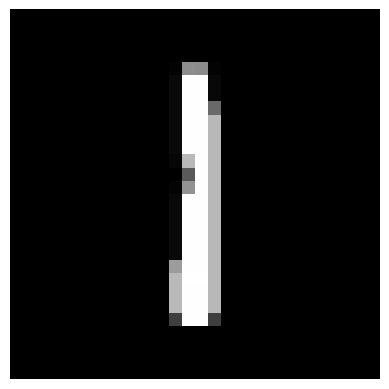

In [6]:
data = np.array(data)

def plot_mnist_image(image_array):
    image = image_array.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.show()

plot_mnist_image(data[2, 1:])

In [7]:
m, n = data.shape
print(m,n)

42000 785


In [8]:
np.random.shuffle(data) # Shuffles all the individual rows
data_dev = data[0:1000].T #Take the first 1000 rows, and transpose the matrix to get 1000 examples as column vectors
data_dev

array([[8, 4, 4, ..., 5, 2, 9],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
Y_dev = data_dev[0] #Takes the first row, which contains all of the answers to the numbers (the Y is what we want)

In [10]:
X_dev = data_dev[1:]
# X_dev = X_dev / 255.

In [11]:
X_dev = X_dev.reshape(28,28,1000)
print(X_dev.shape)

(28, 28, 1000)


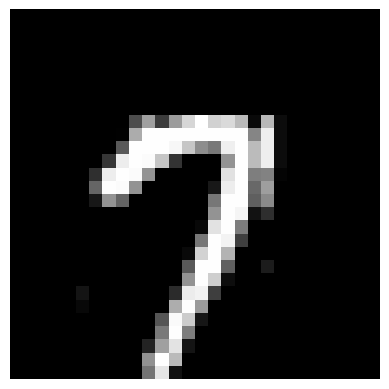

7


In [12]:
# print(X_dev[:,:,1])
plot_mnist_image(X_dev[:,:,6])
print(Y_dev[6])

In [13]:
data_train = data[1000:m].T
Y_train = data_train[0]

In [14]:
X_train= data_train[1:n] #Takes all of the data corresponding to all of the entries
X_train = X_train.reshape(28,28,41000)
# X_dev = X_dev / 255.

In [15]:
def max_pooling(input_data):
    # 24, 24, 2
    input_height, input_width, input_depth = input_data.shape

    # Calculate the output dimensions
    output_height = input_height // 2 # 12
    output_width = input_width // 2 # 12
    output_depth = input_depth # 2 - depth stays the same

    # Initialize the output array and array to store indices
    output_data = np.zeros((output_height, output_width, output_depth))
    indices = np.zeros((output_height, output_width, output_depth, 2), dtype=int)

    # Apply max pooling
    for h in range(output_height):
        for w in range(output_width):
            for d in range(output_depth):
                # Extract the 2x2 region of interest from the input data
                region = input_data[h*2:(h+1)*2, w*2:(w+1)*2, d]
                # Compute the maximum value in the region
                max_val = np.max(region)
                output_data[h, w, d] = max_val
                # Find the indices of the maximum value in the region
                max_indices = np.unravel_index(np.argmax(region), region.shape)
                # Store the indices relative to the region and convert to global indices
                indices[h, w, d] = [h*2 + max_indices[0], w*2 + max_indices[1]]

    return output_data, indices


In [16]:
def der_ReLU(Z):
  return Z > 0

def der_ReLU2(Z, alpha=0.01):
    return np.where(Z > 0, Z, alpha * Z)

def ReLU(Z): # Takes in a scalar, returns a scalar
    return np.maximum(Z, 0)

def ReLU2(Z): # Takes in a scalar, returns a scalar
    return np.maximum(Z, 0)

def sigmoid_prime(z):
  return sigmoid(z)*(1-sigmoid(z))

def sigmoid(z):
    # Compute the sigmoid function element-wise
    return 1.0 / (1.0 + np.exp(-z))

def softmax(Z):
    # Apply softmax column-wise
    exp_Z = np.exp(Z - np.max(Z, axis=0))  # Subtracting the maximum value in each column to avoid overflow
    return exp_Z / np.sum(exp_Z, axis=0)

In [21]:
import math

def params():
    layer_weights = np.random.randn(5, 5, 2) * np.sqrt(2. / 5)
    layer_bias = np.random.randn(24, 24, 2) * np.sqrt(2. / 5)
    layer_output = np.zeros((24,24,2)) #(24,24,2)
    fc_weights = np.random.randn(10, 288) * np.sqrt(2. / 288)
    fc_bias = np.random.randn(10,1) #(10, 1)
    # fc_bias *= 0
    fc_bias = fc_bias.reshape(10, 1)
    return layer_weights, layer_bias, layer_output, fc_weights, fc_bias

def forward_propagation(layer_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias):
    # layer_input (28, 28)
    # layer_weights (5, 5, 2)
    # layer_bias (24, 24, 2)
    # layer_output (24, 24, 2)
    # layer_bias (10, 288)
    # layer_bias (10, 1)
    
    # Convolution
    for i in range(2): # 2 filters in total
        layer_output[:,:,i] = signal.correlate2d(layer_input, layer_weights[:,:,i], mode='valid')
    layer_output = layer_output + layer_bias   # (24, 24, 2)
    
    # Activation layer
    layer_output = ReLU(layer_output)  # (24, 24, 2)
    
    # Pool layer
    layer_pool, layer_indices = max_pooling(layer_output)  # (12, 12, 2)

    
    # Flattening (changed to 288,1)
    layer_pool = layer_pool.reshape(288,1) # (288,1)
    
    # Fully connected layer
    final_output = fc_weights.dot(layer_pool)  # (10, 288) (288, 1) = (10, 1)
    final_output.reshape(10,1) 
    final_output = final_output + fc_bias # (10, 1) + (10, 1) = (10, 1)
    final_output = softmax(final_output) # (10, 1) -> (10, 1)
    
    return layer_output, layer_pool, layer_indices, final_output


def create(Y):
  column_Y = np.zeros((10, 1))
  column_Y[Y] = 1
  column_Y = column_Y.T
  return column_Y.reshape(10,1)

In [22]:
# Backpropogation through layers

def back_prop(layer_input, layer_output, layer_pool, layer_indices, final_output, label, layer_weights, layer_bias, fc_weights, fc_bias):
    # Initalize parameters
    delta_conv_weights = np.zeros((5,5,2))  # (5,5,2)
    delta_conv_bias = np.zeros((24,24,2)) # (24, 24, 2)
    delta_fc_weights = np.zeros((10, 288)) #  (10, 288)
    delta_fc_bias = np.zeros((10, 1)) # (10, 1)
    delta_fc_bias.reshape(10, 1)
    
    # Backpropogate cost
    x = create(label) 
    dZ = (final_output - x) # (10,1) - (10,1) = (10,1) 
    # dZ = dZ.reshape((10,1))
    
    #Backpropogate weights and biases
    layer_pool = layer_pool.reshape(1,288)
    delta_fc_weights = dZ.dot(layer_pool) # (10 x 1 ) (1 x 288) = (10 x 288)
    delta_fc_bias = dZ
    
    # Backpropogate error
    dZ_pool_output = np.dot(fc_weights.T, dZ) * der_ReLU(layer_pool.reshape(288, 1)) #(288 x 10) (10 x 1) = (288 x 1)
    
    # Unflattening
    dZ_pool_output = dZ_pool_output.reshape(12,12,2)
    
    # Unpooling
    dZ_pool_input = np.zeros((24,24,2))
    for i in range(12): # height
        for j in range(12): # width
            for k in range(2): # depth
                # Get the global indices from layer_indices
                x_index, y_index = layer_indices[i, j, k]
                # Assign the gradient from dZ_pool_output to the corresponding position in dZ_pool_input
                dZ_pool_input[x_index, y_index, k] = dZ_pool_output[i, j, k]
    
    # Backpropogating convolutional layer - dZ_pool_input is the output of the convolutional layer
    for i in range(2): # For each filter in the kernel - # of filters = 2
        delta_conv_weights[:,:,i] = signal.correlate(layer_input, dZ_pool_input[:,:,i], mode = "valid") #
    delta_conv_bias = dZ_pool_input

    return delta_conv_weights, delta_conv_bias, delta_fc_weights, delta_fc_bias

def update_params(layer_weights, layer_bias, fc_weights, fc_bias, delta_conv_weights, delta_conv_bias, delta_fc_weights, delta_fc_bias, learning_rate):
    layer_weights 
    layer_weights = layer_weights - learning_rate * delta_conv_weights
    layer_bias = layer_bias - learning_rate * delta_conv_bias
    fc_weights = fc_weights -learning_rate * delta_fc_weights
    fc_bias = fc_bias - learning_rate * delta_fc_bias
    return layer_weights, layer_bias, fc_weights, fc_bias

def get_prediction(A2):
  return np.argmax(A2, 0)

In [40]:
def stochastic_gradient_descent(X_train, X_dev, Y_train, Y_dev, epochs, learning_rate, batch_size):
    # Initialize parameters
    layer_weights, layer_bias, layer_output, fc_weights, fc_bias = params()
    num_examples = X_train.shape[2]
    
    for i in range(epochs):
        print("Epoch:", i+1)
        
        # Generate a random permutation of indices
        permuted_indices = np.random.permutation(X_train.shape[2])

        # Shuffle both X_train and Y_train using the same permutation of indices
        X_train_shuffled = X_train[:, :, permuted_indices]
        Y_train_shuffled = Y_train[permuted_indices]
        for batch_start in range(0, int(X_train.shape[2]/100), batch_size):
            batch_end = min(batch_start + batch_size, num_examples)
            batch_gradients = [0, 0, 0, 0]  # Accumulate gradients over the batch
            for j in range(batch_start, batch_end):
                # print(batch_start, batch_end, j)
                # Get a single training example
                layer_input = X_train_shuffled[:, :, j]
                label = Y_train_shuffled[j]

                # Forward propagation
                layer_output, layer_pool, layer_indices, final_output = forward_propagation(
                    layer_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias
                )

                # Back propagation
                delta_conv_weights, delta_conv_bias, delta_fc_weights, delta_fc_bias = back_prop(
                    layer_input, layer_output, layer_pool, layer_indices, final_output, label,
                    layer_weights, layer_bias, fc_weights, fc_bias
                )

                # Accumulate gradients
                batch_gradients[0] += delta_conv_weights
                batch_gradients[1] += delta_conv_bias
                batch_gradients[2] += delta_fc_weights
                batch_gradients[3] += delta_fc_bias

            # Average gradients after processing the batch
            batch_gradients = [grad / batch_size for grad in batch_gradients]

            # Update parameters after processing the batch
            layer_weights, layer_bias, fc_weights, fc_bias = update_params(
                layer_weights, layer_bias, fc_weights, fc_bias,
                *batch_gradients,  # Use averaged gradients
                learning_rate
            )

        # Get the accuracy
        counter = 0
        for j in range(750):
            test_input = X_dev[:, :, j]
            layer_output, layer_pool, layer_indices, final_output = forward_propagation(
                test_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias
            )
            prediction = get_prediction(final_output)
            predicted_label = prediction[0]
            if Y_dev[j] == predicted_label:
                counter += 1
        print("Accuracy:", counter / 750)

    return layer_weights, layer_bias, layer_output, fc_weights, fc_bias


41000

In [39]:
layer_weights, layer_bias, layer_output, fc_weights, fc_bias = stochastic_gradient_descent(X_train, X_dev, Y_train, Y_dev, 5, 0.5, 20)

Epoch: 1
0 20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20 40
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40 60
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60 80
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80 100
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100 120
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120 140
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140 160
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160 180
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180 200
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200 220
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220 240
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240 260
240
241
242
243
244
245
246
247
248
249
250
251

KeyboardInterrupt: 

In [ ]:
counter = 0

In [ ]:
# Initialize parameters
batch_size = 10
learning_rate = 0.01
epochs = 10
layer_weights, layer_bias, layer_output, fc_weights, fc_bias = params()
counter += 1

In [ ]:
# Generate a random permutation of indices
permuted_indices = np.random.permutation(X_train.shape[2])
# Shuffle both X_train and Y_train using the same permutation of indices
print(X_train.shape)
print(Y_train.shape)
X_train_shuffled = X_train[:, :, permuted_indices]
Y_train_shuffled = Y_train[permuted_indices]
print(X_train_shuffled.shape)
print(Y_train_shuffled.shape)

In [ ]:
# Get a training batch
for batch_start in range(0, len(X_train_shuffled), batch_size):
    batch_end = min(batch_start + batch_size, len(X_train_shuffled))
    batch_gradients = [0, 0, 0, 0]  # Accumulate gradients over the batch
    for j in range(batch_start, batch_end):
        # Get a single training example
        layer_input = X_train_shuffled[:, :, j]
        label = Y_train_shuffled[j]

In [ ]:
# Forward propagation
layer_output, layer_pool, layer_indices, final_output = forward_propagation(
    layer_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias
)

In [ ]:
# Back propagation
delta_conv_weights, delta_conv_bias, delta_fc_weights, delta_fc_bias = back_prop(
    layer_input, layer_output, layer_pool, layer_indices, final_output, label,
    layer_weights, layer_bias, fc_weights, fc_bias
)


In [ ]:
batch_gradients[0] += delta_conv_weights
batch_gradients[1] += delta_conv_bias
batch_gradients[2] += delta_fc_weights
batch_gradients[3] += delta_fc_bias

In [ ]:
# Average gradients after processing the batch
batch_gradients = [grad / batch_size for grad in batch_gradients]

In [ ]:
# Update parameters after processing the batch
layer_weights, layer_bias, fc_weights, fc_bias = update_params(
    layer_weights, layer_bias, fc_weights, fc_bias,
    *batch_gradients,  # Use averaged gradients
    learning_rate
)

In [ ]:
# Get the accuracy
counter = 0
for j in range(750):
    test_input = X_dev[:, :, j]
    layer_output, layer_pool, layer_indices, final_output = forward_propagation(
        test_input, layer_weights, layer_bias, layer_output, fc_weights, fc_bias
    )
    prediction = get_prediction(final_output)
    predicted_label = prediction[0]
    if Y_dev[j] == predicted_label:
        counter += 1
print("Accuracy:", counter / 750)

In [ ]:
# print("layer weights", layer_weights)
# print("layer bias", layer_bias)
# print("layer output", layer_output)
# print("fc weights", fc_weights)
# print("fc_bias", fc_bias)
plt.imshow(layer_output[:,:,1], cmap='gray')
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
# Example training loop
learning_rate = 0.001
num_epochs = 10
batch_size = 32

layer_weights, layer_bias, layer_output, fc_weights, fc_bias = params()

for epoch in range(num_epochs):
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        Y_batch = Y_train[i:i+batch_size]

        for x, y in zip(X_batch, Y_batch):
            layer_output, layer_pool, layer_indices, final_output = forward_propagation(
                x, layer_weights, layer_bias, layer_output, fc_weights, fc_bias
            )

            delta_conv_weights, delta_conv_bias, delta_fc_weights, delta_fc_bias = back_prop(
                x, layer_output, layer_pool, layer_indices, final_output, y, layer_weights, layer_bias, fc_weights, fc_bias
           
